# eq_IO_Taux_bias: Zonal structure of time-mean Zonal Mean Stress (Taux) in the equatorial Indian Ocean

Computes the zonal root mean square error (RMSE) of equatorial Indian Ocean (50°E-110°E) climatological (time and meridional 10°S-10°N average) zonal wind stress (Taux) between model and observations

## Datasets Used for Zonal Mean Stress Comparison

The following reference reanalysis datasets are used to evaluate the model simulations:

- **ERA-Interim (1979-2018)**: The European Centre for Medium-Range Weather Forecasts (ECMWF) reanalysis dataset delivers high-resolution atmospheric and surface variables using modern assimilation techniques, often used for climate and weather analysis.


## Dask Cluster 

Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33207 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33207/status,
Dashboard: /proxy/33207/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46781,Workers: 2
Dashboard: /proxy/33207/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:36525,Total threads: 1
Dashboard: /proxy/40593/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:37469,


## Datasets

In [7]:
from esmvalcore.dataset import Dataset
from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #tier3

In [12]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tauu',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
 "ERA-Interim": 
     Dataset(
     short_name='tauu',
     dataset='ERA-Interim',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3)
}



## Add Ancillary files

In [9]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [13]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

 tauu: attribute positive not present
loaded from file 


## Pre-processors

In [14]:
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import mask_landsea

In [15]:
def prepoc1(cube):
    equatorial_indian_region = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -10., "end_latitude": 10.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)        
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **equatorial_indian_region)
    cube = axis_statistics(cube, operator="mean", axis="y")
    cube = convert_units(cube, units="1e-3 N/m2")
    return cube

def prepoc2(cube):
    equatorial_indian_latext_region = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -25., "end_latitude": 25.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)        
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **equatorial_indian_latext_region)
    cube = convert_units(cube, units="1e-3 N/m2")
    return cube

In [16]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}

# Diagnostics Level 1


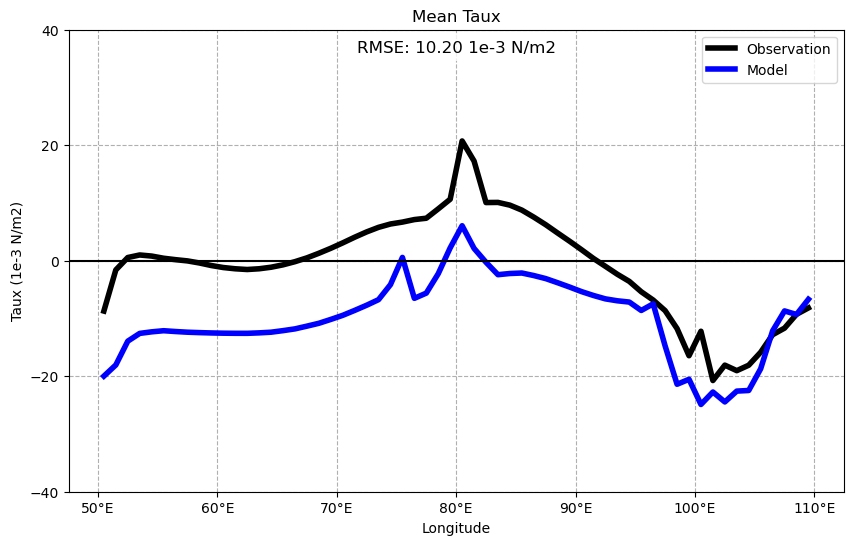

In [18]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

# Function to format x-axis labels with degree symbols and N/S
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

plt.figure(figsize=(10, 6))

obs_data = obs_datasets_prep1["ERA-Interim"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

# Plot observation data in black
qplt.plot(obs_data, color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(model_data, color='blue', label='Model', linewidth=4)

rmse = np.sqrt(np.mean((obs_data.data - model_data.data) ** 2))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Taux (1e-3 N/m2)')
plt.title('Mean Taux')
plt.grid(linestyle='--')
plt.yticks(np.arange(-40,41, step=20))
plt.axhline(y=0, color='black')

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} 1e-3 N/m2', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Setting custom x-axis formatter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding a legend
plt.legend()

# Display the plot
plt.show()

Figure 1: Zonal structure of zonal wind stress (Taux) across the equatorial Indian Ocean (averaged between 10°S–10°N). The black curve represents the reference data, and the blue curve represents the model data. The metric displayed is the zonal RMSE between the model and reference curves.

# Diagnostics Level 2


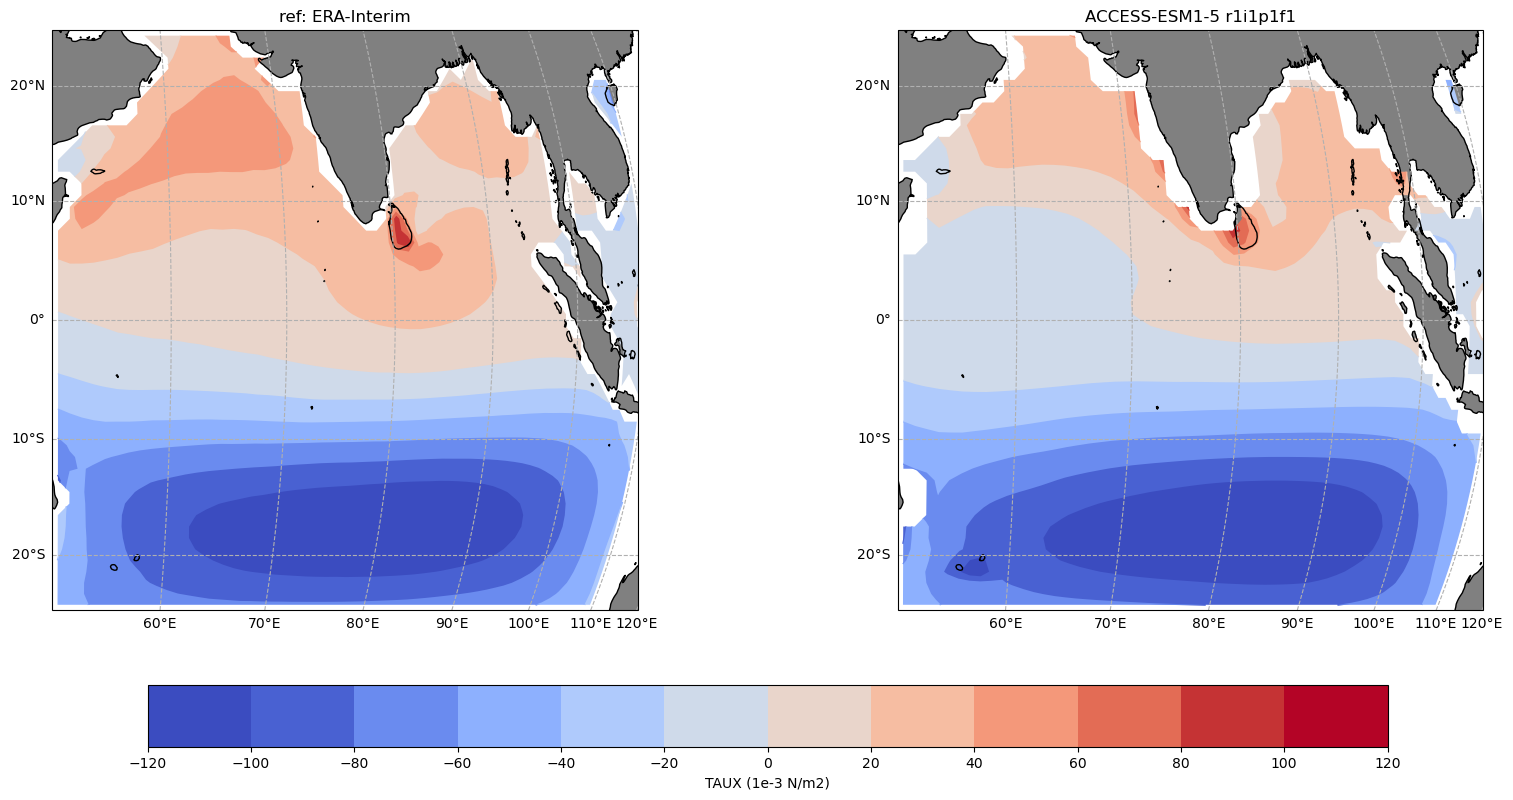

In [23]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Importing numpy for linear space creation
import numpy as np

import iris
import iris.plot as iplt

obs_data = obs_datasets_prep2["ERA-Interim"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# Use the coolwarm colormap
cmap = plt.get_cmap('coolwarm')

# Create a large figure
fig = plt.figure(figsize=(20, 10))  # Adjusted for full width

# Center the map on the Indian Ocean 
proj = ccrs.Orthographic(central_longitude=50, central_latitude=0)

# Define the normalization for the color scale with range of -100 to 100
norm = mcolors.Normalize(vmin=-100, vmax=100)

# Plot #1: contourf for obs
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(obs_data, cmap=cmap, norm=norm, levels=np.arange(-120, 140, 20))
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([50, 110, -25, 25], crs=ccrs.PlateCarree())
ax1.set_title("ref: ERA-Interim")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf for model
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm, levels=np.arange(-120, 140, 20))
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([50, 110, -25, 25], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Add a single colorbar at the bottom
# NOTE: The colorbar will be based on cf2, which already has the correct normalization applied.
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('TAUX (1e-3 N/m2)')
cbar.set_ticks(np.arange(-120, 140, 20))

plt.subplots_adjust(bottom=0.3)  # Further adjust bottom margin to fit the colorbar
plt.show()


Figure 2: Time-mean zonal wind stress (Taux) in the equatorial Indian Ocean. The left map shows the reference data, while the right map displays the model data.